# Beer Label Recognizer

---
**Note: Because this project is data heavy, it is recommended that this notebook be run in a virtual instance. This notebook is set up so that it automatically retrieves tens of thousands of images, vectorizes them and creates a Convolutional Neural Network.**

---

----

## Importing Libraries
---

In [110]:
import numpy as np
import pandas as pd
from urllib import request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os, sys
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Getting Images
---
The following section will be focused on retrieving images provided by the dataset gathered from BreweryDB.com and saving them to your computer.

In [ ]:
df = pd.read_csv('Full_BreweryDB.csv') #Reading the file we saved in the workbook Images to Vectors.py
df = df.reset_index()
df = df.drop(columns=['index','Unnamed: 0'])

In [ ]:
df = df.sort_values(['name']) #Sorting The values based on beer name

In [ ]:
df

Now that we have the database loaded and sorted by beer name, we want to reduce the number of beers we actually model. Why? For one, modeling on beers that are retired and/or were limited edition brews, is unneccesary, because one will most likley not run into one of those beers. Secondly since we are going to make transformed copies of the images, we want to save on as much space as we can.

Since our future plans on this project is to include a recommender system based on the beer you have recognized we are removing beers that do not have 'IBU' (International Bitterness Units) and 'SRM' (Standard Reference Method) in the database.

In [ ]:
df = df[df['labels'].isnull()==False]           #Filtering out beers without labels
df = df[df['ibu'].isnull()==False]              #Filtering out beers without ibu values
df = df[df['srm'].isnull()==False]              #Filtering out beers without srm values
df = df[df['available'].isnull()==False]        #Filtering out beers that are not available
df = df[df['availableId'].isnull()!= 2.0]       #Filtering out beers that are limited edition
df = df[df['isRetired']!= 'Y']                  #Filtering out beers that are retired
df['name'] = df['name'].str.replace('/', '_')   #Some beers contain '/' in their name and causes problems further on
df = df.drop_duplicates(['name'])

In [ ]:
available = df
available = available.reset_index()
available = available.drop(columns='index')

The size by rows and columns of the beers that are available for us to train os is the following:

In [ ]:
available.shape

In [ ]:
available.to_csv('available.csv')

In [ ]:
for i in available['labels']:
    print(i)

As we can see in the previous print statement, the label column consists of multiple links to different sizes of the images. Obviously the bigger the image, the more potential there is to create a better model, however the more memory intensive the process can be, therefore we will compromise and go with the medium sized images that are 256x256 pixels.

Using Python's request library, we can iterate through all those links and download them to our computer.

Note: The code will automatically create folders for organizational purposes

In [ ]:
if not os.path.exists('./labels'):       #Creates new folder for the labels if it does not exist already
    os.makedirs('./labels')

for i in range(len(available)):          #Goes through each link, creates a folder with the beer name, and saves the original label for said beer
    label_url = available['labels'][i].split("'")[7]
    beer_name = available['name'][i]
    if not os.path.exists('./labels/'+beer_name):
        os.makedirs('./labels/'+beer_name)
    request.urlretrieve(label_url, './labels/'+beer_name+'/'+beer_name+'_original_label.png')

## Transforming Imgs
---
If we were to train on the base images of the beer, then we would hypertrain on the perfetion of the label image. However if we take an image of a beer label with our phone camera, the image will not be exactly the same as the original label, no matter how many times we try. To account for this, we will create 30 images for each label that are distorted in some way so that we create some variablilty in our model.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,           #Max rotation in terms of degrees
        width_shift_range=0.2,       #Width stretch range
        height_shift_range=0.2,      #Height stretch range
        shear_range=0.2,             #Shear trasformation range
        zoom_range=0.2,              #Zoom range
        horizontal_flip=False,
        fill_mode='nearest')

Now that we have created the function that will transform those images, it is time to apply them. We will load the original label and apply a random transformation based on the parameters we have set in out `datagen` function.

In [ ]:
for i in range(len(available)):
    beer_name = available['name'][i]
    img = load_img('./labels/'+beer_name+'/'+beer_name+'_original_label.png')
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)       #Note that we will have to reshape the array into a 4 dimentional
    x.shape                             #array so that we can pass it through our datagen function

    n = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='./labels/'+beer_name+'/', save_prefix=beer_name+'_transformed_label', save_format='png'):
        n += 1
        if n > 30:
            break        #Break when we have 30 tranformed images

## Transforming Images to Vectors
---
Now that we have 30 transformed images per beer, as well as one original label, we are ready to transform images to vectros in preparation for the neural network.

Loading this `available.csv` is not required for the first time you run this notebook, however if we already have the images, it makes no sense to waste our time running all the code beforehand, so here is a 'checkpoint' where one can load in order to not retrieve all the images again. 

Note: this `available.csv` should be the same as the one we saved earlier in the notebook, otherwise, we would need to run the whole notebook again.

In [2]:
available = pd.read_csv('available.csv')
available = available.drop(columns='Unnamed: 0')

To vecotize the images, we will use Keras' img_to_array function that takes in an image and vectorizes it. We will then append each vecor to a list of vectors that will represent each individual beer

In [3]:
vectorized_imgs = []
for i in range(len(available)):
    beer_name = available['name'][i]       #Defining beer name and directory for an 'automated' procedure
    directory = './labels/'+beer_name+'/'
    n = 0 
    for filename in os.listdir(directory):
        img = load_img(directory+filename)
        x = img_to_array(img)
        vectorized_imgs.append(x)
        n+=1
        if n > 30:
            break
    if i % 100 == 0:             #Prints out updates every 100 beers           
        print(i , 'out of' ,len(available))

0 out of 1356
10 out of 1356
20 out of 1356
30 out of 1356
40 out of 1356
50 out of 1356
60 out of 1356
70 out of 1356
80 out of 1356
90 out of 1356
100 out of 1356
110 out of 1356
120 out of 1356
130 out of 1356
140 out of 1356
150 out of 1356
160 out of 1356
170 out of 1356
180 out of 1356
190 out of 1356
200 out of 1356
210 out of 1356
220 out of 1356
230 out of 1356
240 out of 1356
250 out of 1356
260 out of 1356
270 out of 1356
280 out of 1356
290 out of 1356
300 out of 1356
310 out of 1356
320 out of 1356
330 out of 1356
340 out of 1356
350 out of 1356
360 out of 1356
370 out of 1356
380 out of 1356
390 out of 1356
400 out of 1356
410 out of 1356
420 out of 1356
430 out of 1356
440 out of 1356
450 out of 1356
460 out of 1356
470 out of 1356
480 out of 1356
490 out of 1356
500 out of 1356
510 out of 1356
520 out of 1356
530 out of 1356
540 out of 1356
550 out of 1356
560 out of 1356
570 out of 1356
580 out of 1356
590 out of 1356
600 out of 1356
610 out of 1356
620 out of 1356
630

In [4]:
print(len(vectorized_imgs))
print(len(available) * 31)

42036

The following code is very similar to the one that vectorized the imgages, however instead of vectorizing it labled each beer with its class. Because the beers are in order and we have been following that with the folder structure, we can categorize beers starting from 0 and ending in 1355 (a total of 1356 classes).

In [6]:
category_list =  []
c=0
for i in range(len(available)):
    beer_name = available['name'][i]
    directory = './labels/'+beer_name+'/'
    n=0
    for filename in os.listdir(directory):
        category_list.append(c)
        n+=1
        if n > 30:
            break
    c+=1

In [7]:
len(vectorized_imgs)
len(category_list)

42036

## Modeling
---
Now that we have the vectorized images, it is time to dive in to the fun part, creating the Convolutional Neural Network that correctly identifies beer labels

In [9]:
X = np.asarray(vectorized_imgs)    #The CNN requires a numpy array as its input
y = category_list

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [10]:
X_train.shape

(31527, 256, 256, 3)

In [11]:
X_train = X_train.reshape(X_train.shape[0], 256,256,3) #Reshaping to ensure consistency in all images
X_test = X_test.reshape(X_test.shape[0],256,256,3)

X_train /= 255    #Normalizing the values of all the pixels
X_test /= 255

In [12]:
Y_train = np_utils.to_categorical(y_train)   # Because beer 5 and 6 are no more similar than beers 70 and 71
Y_test = np_utils.to_categorical(y_test)     # we transform the values to categorical so that proximity in numbers is not a factor

In [13]:
Y_train.shape

(31527, 1356)

In [14]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 32,            # number of filters
                     kernel_size = 5,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(256,256,3))) # shape of input (image)))
cnn_model.add(MaxPooling2D(pool_size=(10,10)))
cnn_model.add(Conv2D(filters = 32,
                    kernel_size=5,
                    activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(10,10)))
cnn_model.add(Flatten())                      #Makinzg a 1D array from our Conv2D layers
cnn_model.add(Dense(128, activation='relu'))  #Hidden Dense layer with 128 nodes
cnn_model.add(Dropout(0.12))                  #Added dropout rate to avoid overfitting on the train data
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.12)) 
cnn_model.add(Dense(len(available), activation='softmax'))  #Output layer that has as many rows as number of beers
cnn_model.compile(loss='categorical_crossentropy',
             optimizer = 'adam',
             metrics=['accuracy'])

In [15]:
cnn_model.fit(X_train,
             Y_train,
             batch_size = 32,
             validation_data=(X_test, Y_test),
             epochs=20,
             verbose=1)

Train on 31527 samples, validate on 10509 samples
Epoch 1/20
31527/31527 [==============================] - 320s 10ms/step - loss: 5.8661 - acc: 0.0263 - val_loss: 3.8455 - val_acc: 0.1298
Epoch 2/20
31527/31527 [==============================] - 338s 11ms/step - loss: 3.5405 - acc: 0.1589 - val_loss: 2.4720 - val_acc: 0.3598
Epoch 3/20
31527/31527 [==============================] - 338s 11ms/step - loss: 2.3961 - acc: 0.3537 - val_loss: 1.4177 - val_acc: 0.6011
Epoch 4/20
31527/31527 [==============================] - 339s 11ms/step - loss: 1.6646 - acc: 0.5174 - val_loss: 0.9534 - val_acc: 0.7288
Epoch 5/20
31527/31527 [==============================] - 345s 11ms/step - loss: 1.2628 - acc: 0.6193 - val_loss: 0.6498 - val_acc: 0.8136
Epoch 6/20
31527/31527 [==============================] - 338s 11ms/step - loss: 1.0034 - acc: 0.6914 - val_loss: 0.5066 - val_acc: 0.8521
Epoch 7/20
31527/31527 [==============================] - 339s 11ms/step - loss: 0.8544 - acc: 0.7346 - val_loss: 0.

In [16]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

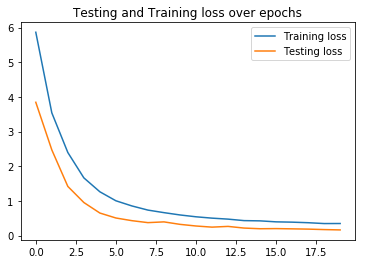

In [113]:
train_loss = cnn_model.history.history['loss']
test_loss = cnn_model.history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.title('Testing and Training loss over epochs')
plt.legend();

In [32]:
for i in range(len(available)):
    beer_name = available['name'][i]
    directory = './labels/'+beer_name+'/'
    n=0
    for filename in os.listdir(directory):
        print(filename)

"Admiral" Stache_transformed_label_0_4037.png
"Admiral" Stache_transformed_label_0_4856.png
"Admiral" Stache_transformed_label_0_9155.png
"Admiral" Stache_transformed_label_0_836.png
"Admiral" Stache_transformed_label_0_3095.png
"Admiral" Stache_transformed_label_0_6861.png
"Admiral" Stache_transformed_label_0_8480.png
"Admiral" Stache_transformed_label_0_9925.png
"Admiral" Stache_transformed_label_0_3124.png
"Admiral" Stache_transformed_label_0_1446.png
"Admiral" Stache_transformed_label_0_1432.png
"Admiral" Stache_transformed_label_0_3151.png
"Admiral" Stache_transformed_label_0_9426.png
"Admiral" Stache_transformed_label_0_6083.png
"Admiral" Stache_transformed_label_0_453.png
"Admiral" Stache_transformed_label_0_2399.png
"Admiral" Stache_transformed_label_0_2476.png
"Admiral" Stache_transformed_label_0_1957.png
"Admiral" Stache_transformed_label_0_902.png
"Admiral" Stache_transformed_label_0_939.png
"Admiral" Stache_transformed_label_0_8174.png
"Admiral" Stache_transformed_label_0_3

2 Turtle Doves_transformed_label_0_3509.png
2 Turtle Doves_transformed_label_0_7865.png
2 Turtle Doves_transformed_label_0_4694.png
2 Turtle Doves_transformed_label_0_2618.png
2 Turtle Doves_transformed_label_0_4685.png
2 Turtle Doves_transformed_label_0_7022.png
2 Turtle Doves_transformed_label_0_5144.png
2 Turtle Doves_transformed_label_0_7847.png
2 Turtle Doves_transformed_label_0_4871.png
2 Turtle Doves_transformed_label_0_831.png
2 Turtle Doves_transformed_label_0_9811.png
2 Turtle Doves_transformed_label_0_4326.png
2 Turtle Doves_transformed_label_0_2085.png
2 Turtle Doves_transformed_label_0_3968.png
2 Turtle Doves_transformed_label_0_3313.png
2 Turtle Doves_transformed_label_0_7930.png
2 Turtle Doves_transformed_label_0_2827.png
20th Anniversary_transformed_label_0_4084.png
20th Anniversary_transformed_label_0_8737.png
20th Anniversary_transformed_label_0_9386.png
20th Anniversary_transformed_label_0_9471.png
20th Anniversary_transformed_label_0_9030.png
20th Anniversary_transf

7 Hop_transformed_label_0_9622.png
7 Hop_transformed_label_0_6609.png
7 Hop_transformed_label_0_5262.png
7 Hop_transformed_label_0_2814.png
7 Hop_transformed_label_0_952.png
7 Hop_transformed_label_0_6229.png
7 Hop_transformed_label_0_7655.png
7 Hop_transformed_label_0_8422.png
7 Hop_transformed_label_0_1170.png
7 Hop_transformed_label_0_7541.png
7 Hop_transformed_label_0_4595.png
7 Hop_transformed_label_0_689.png
7 Hop_transformed_label_0_6396.png
7 Hop_transformed_label_0_1614.png
7 Hop_transformed_label_0_4599.png
7 Hop_transformed_label_0_6541.png
7 Hop_transformed_label_0_3326.png
7 Hop_transformed_label_0_5439.png
7 Hop_transformed_label_0_1975.png
7 Hop_transformed_label_0_1832.png
7 Hop_transformed_label_0_5727.png
7 Hop_transformed_label_0_7157.png
7 Hop_transformed_label_0_1317.png
7 Hop_transformed_label_0_2448.png
7 Hop_transformed_label_0_5399.png
7 Hop_transformed_label_0_421.png
7 Hop_transformed_label_0_8115.png
7 Hop_original_label.png
7 Hop_transformed_label_0_8486.pn

Alaskan Stout_transformed_label_0_2482.png
Alaskan Stout_transformed_label_0_4932.png
Alaskan Stout_transformed_label_0_6308.png
Alaskan Stout_transformed_label_0_7761.png
Alaskan Stout_transformed_label_0_5368.png
Alaskan Stout_transformed_label_0_1933.png
Alaskan Stout_transformed_label_0_3080.png
Alaskan Stout_transformed_label_0_8777.png
Alaskan Stout_transformed_label_0_5642.png
Alaskan Stout_transformed_label_0_2388.png
Alaskan Stout_transformed_label_0_4169.png
Alaskan Stout_transformed_label_0_8230.png
Alaskan Stout_transformed_label_0_6834.png
Alaskan Stout_original_label.png
Alaskan Stout_transformed_label_0_5838.png
Alaskan Stout_transformed_label_0_6733.png
Alaskan Stout_transformed_label_0_635.png
Alaskan Stout_transformed_label_0_127.png
Alaskan Stout_transformed_label_0_916.png
Alaskan Stout_transformed_label_0_5938.png
Alaskan Stout_transformed_label_0_2490.png
Alaskan Stout_transformed_label_0_3909.png
Alaskan Stout_transformed_label_0_3571.png
Alaskan Stout_transforme

Anaheim 1888_transformed_label_0_9296.png
Anaheim 1888_transformed_label_0_910.png
Anaheim 1888_transformed_label_0_8998.png
Anaheim 1888_transformed_label_0_5928.png
Anaheim 1888_transformed_label_0_2335.png
Anaheim 1888_transformed_label_0_4045.png
Anaheim 1888_transformed_label_0_5411.png
Anaheim 1888_transformed_label_0_6042.png
Anaheim 1888_transformed_label_0_4960.png
Anaheim 1888_transformed_label_0_6245.png
Anaheim Bockbier_transformed_label_0_7334.png
Anaheim Bockbier_transformed_label_0_4760.png
Anaheim Bockbier_transformed_label_0_2292.png
Anaheim Bockbier_transformed_label_0_5557.png
Anaheim Bockbier_transformed_label_0_8383.png
Anaheim Bockbier_transformed_label_0_4889.png
Anaheim Bockbier_transformed_label_0_5064.png
Anaheim Bockbier_transformed_label_0_5253.png
Anaheim Bockbier_transformed_label_0_5409.png
Anaheim Bockbier_transformed_label_0_8599.png
Anaheim Bockbier_transformed_label_0_5675.png
Anaheim Bockbier_transformed_label_0_7222.png
Anaheim Bockbier_transformed_

B_A_Y_S_transformed_label_0_4574.png
B_A_Y_S_transformed_label_0_7768.png
B_A_Y_S_transformed_label_0_1314.png
B_A_Y_S_transformed_label_0_313.png
B_A_Y_S_transformed_label_0_7237.png
B_A_Y_S_transformed_label_0_4855.png
B_A_Y_S_transformed_label_0_4641.png
B_A_Y_S_transformed_label_0_4382.png
B_A_Y_S_transformed_label_0_3432.png
B_A_Y_S_transformed_label_0_2403.png
B_A_Y_S_transformed_label_0_8901.png
B_A_Y_S_transformed_label_0_8061.png
B_A_Y_S_transformed_label_0_2098.png
B_A_Y_S_transformed_label_0_1190.png
B_A_Y_S_transformed_label_0_169.png
B_A_Y_S_transformed_label_0_108.png
B_A_Y_S_transformed_label_0_3653.png
B_A_Y_S_transformed_label_0_7656.png
B_A_Y_S - Tequila Barrel Aged (Ghost 075)_transformed_label_0_3379.png
B_A_Y_S - Tequila Barrel Aged (Ghost 075)_transformed_label_0_3538.png
B_A_Y_S - Tequila Barrel Aged (Ghost 075)_transformed_label_0_8265.png
B_A_Y_S - Tequila Barrel Aged (Ghost 075)_transformed_label_0_795.png
B_A_Y_S - Tequila Barrel Aged (Ghost 075)_transformed_

Bass Ackwards Berryblue Ale_transformed_label_0_4339.png
Bass Ackwards Berryblue Ale_transformed_label_0_8914.png
Bass Ackwards Berryblue Ale_transformed_label_0_4561.png
Bass Ackwards Berryblue Ale_transformed_label_0_7604.png
Bass Ackwards Berryblue Ale_transformed_label_0_9509.png
Bass Ackwards Berryblue Ale_transformed_label_0_8695.png
Bass Ackwards Berryblue Ale_transformed_label_0_6994.png
Bass Ackwards Berryblue Ale_transformed_label_0_913.png
Bass Ackwards Berryblue Ale_transformed_label_0_9140.png
Bass Ackwards Berryblue Ale_transformed_label_0_9847.png
Bass Ackwards Berryblue Ale_transformed_label_0_7933.png
Bass Ackwards Berryblue Ale_transformed_label_0_1895.png
Bass Ackwards Berryblue Ale_transformed_label_0_3195.png
Bass Ackwards Berryblue Ale_transformed_label_0_5037.png
Bass Ackwards Berryblue Ale_transformed_label_0_6406.png
Bass Ackwards Berryblue Ale_transformed_label_0_6061.png
Bass Ackwards Berryblue Ale_transformed_label_0_7782.png
Bass Ackwards Berryblue Ale_tran

Big Eye_transformed_label_0_310.png
Big Eye_transformed_label_0_2565.png
Big Eye_transformed_label_0_1511.png
Big Eye_original_label.png
Big Eye_transformed_label_0_785.png
Big Eye_transformed_label_0_6455.png
Big Eye_transformed_label_0_827.png
Big Eye_transformed_label_0_3381.png
Big Eye_transformed_label_0_1807.png
Big Eye_transformed_label_0_1191.png
Big Eye_transformed_label_0_7565.png
Big Eye_transformed_label_0_5200.png
Big Eye_transformed_label_0_733.png
Big Eye_transformed_label_0_2410.png
Big Eye_transformed_label_0_6245.png
Big Eye_transformed_label_0_3905.png
Big Eye_transformed_label_0_1611.png
Big Eye_transformed_label_0_7987.png
Big Eye_transformed_label_0_8413.png
Big Eye_transformed_label_0_3719.png
Big Eye_transformed_label_0_6394.png
Big Eye_transformed_label_0_4444.png
Big Eye_transformed_label_0_3609.png
Big Eye_transformed_label_0_7704.png
Big Eye_transformed_label_0_7835.png
Big Eye_transformed_label_0_4732.png
Big Eye_transformed_label_0_1906.png
Big Eye_transfo

Black Pale Ale_transformed_label_0_3158.png
Black Pale Ale_transformed_label_0_9094.png
Black Pale Ale_transformed_label_0_4938.png
Black Pale Ale_transformed_label_0_2060.png
Black Pale Ale_transformed_label_0_373.png
Black Pale Ale_transformed_label_0_5257.png
Black Pale Ale_transformed_label_0_8930.png
Black Pale Ale_transformed_label_0_3806.png
Black Pale Ale_transformed_label_0_9783.png
Black Pale Ale_transformed_label_0_4821.png
Black Pale Ale_transformed_label_0_3611.png
Black Pale Ale_transformed_label_0_2655.png
Black Pale Ale_transformed_label_0_2927.png
Black Pale Ale_transformed_label_0_8040.png
Black Pale Ale_transformed_label_0_1394.png
Black Pale Ale_original_label.png
Black Pale Ale_transformed_label_0_6720.png
Black Pale Ale_transformed_label_0_5148.png
Black Pale Ale_transformed_label_0_898.png
Black Pale Ale_transformed_label_0_4576.png
Black Pale Ale_transformed_label_0_8137.png
Black Pale Ale_transformed_label_0_3241.png
Black Pale Ale_transformed_label_0_1868.png


Boardwalk Black Rye IPA_transformed_label_0_3068.png
Boardwalk Black Rye IPA_transformed_label_0_3513.png
Boardwalk Black Rye IPA_transformed_label_0_416.png
Boardwalk Black Rye IPA_transformed_label_0_6613.png
Boardwalk Black Rye IPA_transformed_label_0_3677.png
Boardwalk Black Rye IPA_transformed_label_0_9086.png
Boardwalk Black Rye IPA_transformed_label_0_5789.png
Boardwalk Black Rye IPA_transformed_label_0_9027.png
Boardwalk Black Rye IPA_transformed_label_0_8023.png
Boardwalk Black Rye IPA_transformed_label_0_8272.png
Boardwalk Black Rye IPA_transformed_label_0_3317.png
Boardwalk Black Rye IPA_transformed_label_0_9326.png
Boardwalk Black Rye IPA_transformed_label_0_9909.png
Boardwalk Black Rye IPA_transformed_label_0_7478.png
Boardwalk Black Rye IPA_transformed_label_0_2737.png
Boardwalk Black Rye IPA_transformed_label_0_1628.png
Boardwalk Black Rye IPA_transformed_label_0_2792.png
Boardwalk Black Rye IPA_transformed_label_0_5536.png
Boardwalk Black Rye IPA_transformed_label_0_322

Breakaway IPA_transformed_label_0_7370.png
Breakaway IPA_transformed_label_0_7809.png
Breakaway IPA_transformed_label_0_4634.png
Breakaway IPA_transformed_label_0_3716.png
Breakaway IPA_transformed_label_0_4805.png
Breakaway IPA_transformed_label_0_1485.png
Breakaway IPA_transformed_label_0_2958.png
Breakaway IPA_transformed_label_0_21.png
Breakaway IPA_transformed_label_0_5608.png
Breakaway IPA_transformed_label_0_1504.png
Breakaway IPA_transformed_label_0_7248.png
Breakaway IPA_transformed_label_0_9239.png
Breakaway IPA_transformed_label_0_1635.png
Breakaway IPA_transformed_label_0_4887.png
Breakaway IPA_transformed_label_0_4462.png
Breakaway IPA_transformed_label_0_6032.png
Breakaway IPA_original_label.png
Breakaway IPA_transformed_label_0_9804.png
Breakaway IPA_transformed_label_0_5060.png
Breakaway IPA_transformed_label_0_8115.png
Breakaway IPA_transformed_label_0_9032.png
Breakaway IPA_transformed_label_0_8318.png
Breakaway IPA_transformed_label_0_53.png
Breakaway IPA_transformed

Burn Out_transformed_label_0_6117.png
Burn Out_transformed_label_0_6427.png
Burn Out_transformed_label_0_4827.png
Burn Out_transformed_label_0_1622.png
Burn the Boats_transformed_label_0_7710.png
Burn the Boats_transformed_label_0_3794.png
Burn the Boats_transformed_label_0_617.png
Burn the Boats_transformed_label_0_9103.png
Burn the Boats_transformed_label_0_8130.png
Burn the Boats_transformed_label_0_9657.png
Burn the Boats_transformed_label_0_9239.png
Burn the Boats_transformed_label_0_2053.png
Burn the Boats_transformed_label_0_4519.png
Burn the Boats_transformed_label_0_6698.png
Burn the Boats_transformed_label_0_6108.png
Burn the Boats_transformed_label_0_8481.png
Burn the Boats_transformed_label_0_598.png
Burn the Boats_transformed_label_0_8241.png
Burn the Boats_transformed_label_0_9689.png
Burn the Boats_transformed_label_0_7160.png
Burn the Boats_transformed_label_0_1154.png
Burn the Boats_transformed_label_0_8052.png
Burn the Boats_transformed_label_0_6163.png
Burn the Boats

Catoctin Ale_transformed_label_0_1128.png
Catoctin Ale_transformed_label_0_3692.png
Catoctin Ale_transformed_label_0_2674.png
Catoctin Ale_transformed_label_0_164.png
Catoctin Ale_transformed_label_0_8635.png
Catoctin Ale_transformed_label_0_7280.png
Catoctin Ale_transformed_label_0_3091.png
Catoctin Ale_transformed_label_0_7860.png
Catoctin Ale_transformed_label_0_5163.png
Catoctin Ale_transformed_label_0_5431.png
Catoctin Ale_transformed_label_0_8293.png
Catoctin Ale_transformed_label_0_3678.png
Catoctin Ale_transformed_label_0_4567.png
Catoctin Ale_transformed_label_0_1100.png
Catoctin Ale_transformed_label_0_2717.png
Catoctin Ale_transformed_label_0_2838.png
Catoctin Ale_transformed_label_0_3425.png
Catoctin Ale_transformed_label_0_3462.png
Catoctin Ale_transformed_label_0_2139.png
Cave City Lager_transformed_label_0_3614.png
Cave City Lager_transformed_label_0_8104.png
Cave City Lager_transformed_label_0_8360.png
Cave City Lager_transformed_label_0_5351.png
Cave City Lager_transfo

Chilly Water_transformed_label_0_8307.png
Chilly Water_transformed_label_0_5591.png
Chilly Water_transformed_label_0_9030.png
Chilly Water_transformed_label_0_1070.png
Chilly Water_transformed_label_0_2972.png
Chilly Water_transformed_label_0_7477.png
Chilly Water_transformed_label_0_4766.png
Chilly Water_transformed_label_0_1222.png
Chilly Water_original_label.png
Chilly Water_transformed_label_0_9502.png
Chilly Water_transformed_label_0_9450.png
Chilly Water_transformed_label_0_3273.png
Chilly Water_transformed_label_0_5523.png
Chilly Water_transformed_label_0_1929.png
Chilly Water_transformed_label_0_2496.png
Chilly Water_transformed_label_0_7121.png
Chilly Water_transformed_label_0_4415.png
Chilly Water_transformed_label_0_806.png
Chilly Water_transformed_label_0_5056.png
Chilly Water_transformed_label_0_9963.png
Chilly Water_transformed_label_0_6739.png
Chilly Water_transformed_label_0_1603.png
Chilly Water_transformed_label_0_6749.png
Chilly Water_transformed_label_0_1737.png
Chi

Coffee Bender_transformed_label_0_9261.png
Coffee Bender_transformed_label_0_1009.png
Coffee Bender_transformed_label_0_7388.png
Coffee Bender_transformed_label_0_6516.png
Coffee Bender_original_label.png
Coffee Bender_transformed_label_0_5345.png
Coffee Bender_transformed_label_0_6495.png
Coffee Bender_transformed_label_0_9292.png
Coffee Bender_transformed_label_0_2087.png
Coffee Bender_transformed_label_0_1930.png
Coffee Bender_transformed_label_0_6465.png
Coffee Bender_transformed_label_0_854.png
Coffee Bender_transformed_label_0_7138.png
Coffee Bender_transformed_label_0_4053.png
Coffee Bender_transformed_label_0_4560.png
Coffee Bender_transformed_label_0_8568.png
Coffee Bender_transformed_label_0_2770.png
Coffee Bender_transformed_label_0_1518.png
Coffee Bender_transformed_label_0_1239.png
Coffee Bender_transformed_label_0_6911.png
Coffee Bender_transformed_label_0_3357.png
Coffee Bender_transformed_label_0_3095.png
Coffee Bender_transformed_label_0_7918.png
Coffee Bender_transfor

Counter Clockweisse_transformed_label_0_8883.png
Counter Clockweisse_transformed_label_0_9166.png
Counter Clockweisse_transformed_label_0_1846.png
Counter Clockweisse_transformed_label_0_9410.png
Counter Clockweisse_transformed_label_0_1450.png
Counter Clockweisse_transformed_label_0_2475.png
Counter Clockweisse_transformed_label_0_7070.png
Counter Clockweisse_transformed_label_0_3948.png
Counter Clockweisse_transformed_label_0_6030.png
Counter Clockweisse_transformed_label_0_6335.png
Counter Clockweisse_transformed_label_0_9090.png
Counter Clockweisse_transformed_label_0_2212.png
Country Roots_transformed_label_0_5752.png
Country Roots_transformed_label_0_3736.png
Country Roots_transformed_label_0_8411.png
Country Roots_transformed_label_0_6867.png
Country Roots_transformed_label_0_9607.png
Country Roots_transformed_label_0_210.png
Country Roots_transformed_label_0_8516.png
Country Roots_transformed_label_0_9928.png
Country Roots_transformed_label_0_5147.png
Country Roots_transformed_

DNR_transformed_label_0_1831.png
DNR_transformed_label_0_869.png
DNR_transformed_label_0_6530.png
DNR_transformed_label_0_7678.png
DNR_transformed_label_0_4504.png
DNR_transformed_label_0_9758.png
DNR_transformed_label_0_3581.png
DNR_transformed_label_0_3192.png
DNR_transformed_label_0_8520.png
DNR_transformed_label_0_4289.png
DNR_transformed_label_0_3163.png
DNR_transformed_label_0_6529.png
DNR_transformed_label_0_9716.png
DNR_transformed_label_0_4110.png
DNR_transformed_label_0_582.png
DNR_transformed_label_0_7379.png
DNR_transformed_label_0_7288.png
DNR_transformed_label_0_4164.png
DNR_transformed_label_0_7924.png
DNR_transformed_label_0_4920.png
DNR_transformed_label_0_5877.png
DNR_transformed_label_0_8410.png
DNR_transformed_label_0_1415.png
DNR_transformed_label_0_5710.png
DNR_transformed_label_0_8609.png
DNR_transformed_label_0_5705.png
DNR_transformed_label_0_5949.png
DNR_transformed_label_0_3021.png
DNR_transformed_label_0_4679.png
DNR_transformed_label_0_5462.png
Dad’s Little

Detour_transformed_label_0_7980.png
Detour_transformed_label_0_4943.png
Detour_transformed_label_0_5115.png
Detour_transformed_label_0_6622.png
Detour_transformed_label_0_4871.png
Detour_transformed_label_0_3347.png
Detour_transformed_label_0_9392.png
Detour_transformed_label_0_2247.png
Detour_transformed_label_0_3410.png
Detour_transformed_label_0_8617.png
Detour_transformed_label_0_9113.png
Detour_transformed_label_0_5272.png
Detour_transformed_label_0_174.png
Detour_transformed_label_0_863.png
Detour_transformed_label_0_9580.png
Detour_transformed_label_0_6662.png
Detour_transformed_label_0_1159.png
Detour_transformed_label_0_7507.png
Detour_transformed_label_0_3512.png
Detour_transformed_label_0_2608.png
Detour_transformed_label_0_3226.png
Detour_transformed_label_0_6163.png
Detour_transformed_label_0_5213.png
Detour_transformed_label_0_1506.png
Detour_transformed_label_0_6896.png
Detour_transformed_label_0_1989.png
Detour_transformed_label_0_29.png
Detour_transformed_label_0_8860.

Double Bag_transformed_label_0_8334.png
Double Bag_transformed_label_0_5924.png
Double Bag_transformed_label_0_5928.png
Double Bag_transformed_label_0_7600.png
Double Bag_transformed_label_0_8248.png
Double Bag_transformed_label_0_9229.png
Double Bag_transformed_label_0_4705.png
Double Bag_transformed_label_0_7398.png
Double Bag_transformed_label_0_2774.png
Double Bag_transformed_label_0_8681.png
Double Bag_transformed_label_0_4174.png
Double Bag_transformed_label_0_3221.png
Double Bag_transformed_label_0_2149.png
Double Bag_transformed_label_0_945.png
Double Bag_transformed_label_0_9938.png
Double Bag_transformed_label_0_4787.png
Double Bag_transformed_label_0_7875.png
Double Bag_transformed_label_0_5986.png
Double Bag_transformed_label_0_1860.png
Double Bag_transformed_label_0_7811.png
Double Bag_transformed_label_0_7779.png
Double Bag_transformed_label_0_9391.png
Double Bag_transformed_label_0_7216.png
Double Bag_transformed_label_0_2394.png
Double Bag_transformed_label_0_5518.png
D

ESA_transformed_label_0_2152.png
ESA_transformed_label_0_8986.png
ESA_transformed_label_0_5643.png
ESA_transformed_label_0_1149.png
ESA_transformed_label_0_5148.png
ESA_transformed_label_0_8212.png
ESA_transformed_label_0_5498.png
ESA_transformed_label_0_3483.png
ESA_transformed_label_0_1649.png
ESA_transformed_label_0_3179.png
ESA_transformed_label_0_3864.png
ESA_transformed_label_0_9980.png
ESA_transformed_label_0_5074.png
ESA_transformed_label_0_541.png
ESA_transformed_label_0_9212.png
ESA_transformed_label_0_6859.png
ESA_transformed_label_0_592.png
ESA_transformed_label_0_4972.png
ESA_transformed_label_0_9857.png
ESA_transformed_label_0_1556.png
ESA_transformed_label_0_4041.png
ESA_transformed_label_0_3893.png
ESA_transformed_label_0_8539.png
ESA_transformed_label_0_8807.png
ESA_transformed_label_0_601.png
ESA_transformed_label_0_5318.png
ESA_transformed_label_0_1739.png
ESA_original_label.png
ESA_transformed_label_0_5360.png
ESA_transformed_label_0_6239.png
ESA_transformed_label_0

Epic Thornbridge Stout_transformed_label_0_543.png
Epic Thornbridge Stout_transformed_label_0_1956.png
Epic Thornbridge Stout_transformed_label_0_1219.png
Epic Thornbridge Stout_transformed_label_0_1212.png
Epic Thornbridge Stout_transformed_label_0_8668.png
Epic Thornbridge Stout_transformed_label_0_9982.png
Epic Thornbridge Stout_transformed_label_0_5242.png
Epic Thornbridge Stout_transformed_label_0_7677.png
Epic Thornbridge Stout_transformed_label_0_1039.png
Epic Thornbridge Stout_transformed_label_0_3229.png
Epic Thornbridge Stout_transformed_label_0_3939.png
Epic Thornbridge Stout_transformed_label_0_4138.png
Epic Thornbridge Stout_transformed_label_0_7290.png
Epic Thornbridge Stout_transformed_label_0_6219.png
Epitaph Bourbon Barrel Aged Russian Imperial Stout_transformed_label_0_1983.png
Epitaph Bourbon Barrel Aged Russian Imperial Stout_transformed_label_0_580.png
Epitaph Bourbon Barrel Aged Russian Imperial Stout_transformed_label_0_7271.png
Epitaph Bourbon Barrel Aged Russia

Farm Girl Saison_transformed_label_0_1736.png
Farm Girl Saison_transformed_label_0_422.png
Farm Girl Saison_transformed_label_0_1587.png
Farm Girl Saison_transformed_label_0_1643.png
Farm Girl Saison_transformed_label_0_2759.png
Farm Girl Saison_transformed_label_0_3415.png
Farm Girl Saison_transformed_label_0_402.png
Farm Girl Saison_transformed_label_0_8047.png
Farm Girl Saison_transformed_label_0_4129.png
Farm Girl Saison_transformed_label_0_1999.png
Farm Girl Saison_transformed_label_0_4804.png
Farm Girl Saison_original_label.png
Farm Girl Saison_transformed_label_0_4380.png
Farm Girl Saison_transformed_label_0_8538.png
Farm Girl Saison_transformed_label_0_4946.png
Farm Girl Saison_transformed_label_0_7752.png
Farm Girl Saison_transformed_label_0_6088.png
Farm Girl Saison_transformed_label_0_4351.png
Farm Girl Saison_transformed_label_0_3391.png
Farm Girl Saison_transformed_label_0_2509.png
Farm Girl Saison_transformed_label_0_5860.png
Farm Girl Saison_transformed_label_0_2647.png


Fluffy White Rabbits_transformed_label_0_9672.png
Fluffy White Rabbits_transformed_label_0_9003.png
Fluffy White Rabbits_transformed_label_0_2459.png
Fluffy White Rabbits_original_label.png
Fluffy White Rabbits_transformed_label_0_5491.png
Fluffy White Rabbits_transformed_label_0_5607.png
Fluffy White Rabbits_transformed_label_0_2450.png
Fluffy White Rabbits_transformed_label_0_8830.png
Fluffy White Rabbits_transformed_label_0_2173.png
Fluffy White Rabbits_transformed_label_0_9249.png
Fluffy White Rabbits_transformed_label_0_5315.png
Fluffy White Rabbits_transformed_label_0_9547.png
Fluffy White Rabbits_transformed_label_0_807.png
Fluffy White Rabbits_transformed_label_0_716.png
Fluffy White Rabbits_transformed_label_0_2750.png
Fluffy White Rabbits_transformed_label_0_1534.png
Fluffy White Rabbits_transformed_label_0_1573.png
Fluffy White Rabbits_transformed_label_0_5292.png
Fluffy White Rabbits_transformed_label_0_325.png
Fluffy White Rabbits_transformed_label_0_5171.png
Fluffy White 

Full Throttle_transformed_label_0_9998.png
Full Throttle_transformed_label_0_560.png
Full Throttle_transformed_label_0_1821.png
Full Throttle_transformed_label_0_6004.png
Full Throttle_transformed_label_0_5005.png
Full Throttle_transformed_label_0_8929.png
Full Throttle_transformed_label_0_7235.png
Full Throttle_transformed_label_0_3429.png
Full Throttle_transformed_label_0_7345.png
Full Throttle_transformed_label_0_390.png
Full Throttle_transformed_label_0_4343.png
Full Throttle_transformed_label_0_8256.png
Full Throttle_transformed_label_0_4862.png
Full Throttle_transformed_label_0_6272.png
Full Throttle_transformed_label_0_2828.png
Full Throttle_transformed_label_0_922.png
Full Throttle_transformed_label_0_3919.png
Full Throttle_transformed_label_0_6102.png
Full Throttle_transformed_label_0_9408.png
Full Throttle_transformed_label_0_3906.png
Full Throttle_transformed_label_0_78.png
Full Throttle_transformed_label_0_3199.png
Full Throttle_transformed_label_0_8973.png
Full Throttle_tr

Gold Coin_transformed_label_0_8973.png
Gold Coin_transformed_label_0_8523.png
Gold Coin_transformed_label_0_8221.png
Gold Coin_transformed_label_0_9957.png
Gold Coin_transformed_label_0_5074.png
Gold Coin_transformed_label_0_2222.png
Gold Coin_transformed_label_0_9600.png
Gold Coin_transformed_label_0_8170.png
Gold Coin_transformed_label_0_1448.png
Gold Coin_transformed_label_0_8518.png
Gold Coin_transformed_label_0_3877.png
Gold Coin_transformed_label_0_7259.png
Gold Coin_transformed_label_0_11.png
Gold Coin_original_label.png
Gold Coin_transformed_label_0_2223.png
Gold Coin_transformed_label_0_2187.png
Gold Coin_transformed_label_0_5599.png
Gold Coin_transformed_label_0_5516.png
Gold Coin_transformed_label_0_2247.png
Gold Coin_transformed_label_0_3695.png
Gold Coin_transformed_label_0_9167.png
Gold Coin_transformed_label_0_3119.png
Gold Coin_transformed_label_0_2189.png
Gold Coin_transformed_label_0_1827.png
Gold Coin_transformed_label_0_4448.png
Gold Coin_transformed_label_0_781.png

Gravitation_transformed_label_0_7225.png
Gravitation_transformed_label_0_199.png
Gravitation_transformed_label_0_5831.png
Gravitation_transformed_label_0_3297.png
Gravitation_transformed_label_0_4295.png
Gravitation_transformed_label_0_2846.png
Gravitation_transformed_label_0_4023.png
Gravitation_transformed_label_0_2766.png
Gravitation_transformed_label_0_1687.png
Gravitation_transformed_label_0_3059.png
Gravitation_transformed_label_0_5004.png
Gravitation_transformed_label_0_1668.png
Gravitation_transformed_label_0_2851.png
Gravitation_transformed_label_0_8556.png
Gravitation_transformed_label_0_9221.png
Gravitation_transformed_label_0_8420.png
Gravitation_transformed_label_0_6829.png
Gravitation_transformed_label_0_2459.png
Gravitation_transformed_label_0_7641.png
Gravitation_transformed_label_0_4026.png
Gravitation_transformed_label_0_8359.png
Gravitation_transformed_label_0_3383.png
Gravitation_transformed_label_0_4581.png
Gravitation_transformed_label_0_4764.png
Gravitation_trans

Hardcore IPA_transformed_label_0_8486.png
Hardcore IPA_transformed_label_0_3366.png
Hardcore IPA_transformed_label_0_6377.png
Hardcore IPA_original_label.png
Hardcore IPA_transformed_label_0_7934.png
Hardcore IPA_transformed_label_0_557.png
Hardcore IPA_transformed_label_0_6292.png
Hardcore IPA_transformed_label_0_9418.png
Hardcore IPA_transformed_label_0_210.png
Hardcore IPA_transformed_label_0_4817.png
Hardcore IPA_transformed_label_0_6824.png
Hardcore IPA_transformed_label_0_3448.png
Hardcore IPA_transformed_label_0_1091.png
Hardcore IPA_transformed_label_0_7600.png
Hardcore IPA_transformed_label_0_8096.png
Hardcore IPA_transformed_label_0_6973.png
Hardcore IPA_transformed_label_0_3652.png
Hardcore IPA_transformed_label_0_8152.png
Hardcore IPA_transformed_label_0_9001.png
Hardcore IPA_transformed_label_0_2985.png
Hardcore IPA_transformed_label_0_8319.png
Hardcore IPA_transformed_label_0_1782.png
Hardcore IPA_transformed_label_0_7950.png
Hardcore IPA_transformed_label_0_5361.png
Hard

High Altitude Hellas_transformed_label_0_6208.png
High Altitude Hellas_transformed_label_0_2166.png
High Altitude Hellas_transformed_label_0_9431.png
High Altitude Hellas_transformed_label_0_5115.png
High Altitude Hellas_transformed_label_0_4265.png
High Altitude Hellas_transformed_label_0_9757.png
High Altitude Hellas_transformed_label_0_1275.png
High Altitude Hellas_transformed_label_0_4232.png
High Altitude Hellas_transformed_label_0_4512.png
High Altitude Hellas_transformed_label_0_4038.png
High Altitude Hellas_transformed_label_0_7564.png
High Altitude Hellas_transformed_label_0_6659.png
High Brass_transformed_label_0_4674.png
High Brass_transformed_label_0_5522.png
High Brass_transformed_label_0_1829.png
High Brass_transformed_label_0_5811.png
High Brass_transformed_label_0_2235.png
High Brass_transformed_label_0_7967.png
High Brass_transformed_label_0_9879.png
High Brass_transformed_label_0_6235.png
High Brass_transformed_label_0_707.png
High Brass_transformed_label_0_8738.png
H

Hop Crisis_transformed_label_0_908.png
Hop Crisis_transformed_label_0_9727.png
Hop Crisis_transformed_label_0_9395.png
Hop Crisis_transformed_label_0_6690.png
Hop Crisis_transformed_label_0_4614.png
Hop Crisis_transformed_label_0_9746.png
Hop Crisis_transformed_label_0_5540.png
Hop Crisis_transformed_label_0_3510.png
Hop Crisis_transformed_label_0_7265.png
Hop Crisis_transformed_label_0_4567.png
Hop Crisis_transformed_label_0_6267.png
Hop Crisis_transformed_label_0_6683.png
Hop Crisis_transformed_label_0_8893.png
Hop Crisis_transformed_label_0_3312.png
Hop Crisis_transformed_label_0_6191.png
Hop Crisis_transformed_label_0_1146.png
Hop Crisis_transformed_label_0_7877.png
Hop Crisis_transformed_label_0_7074.png
Hop Crisis_transformed_label_0_6935.png
Hop Crisis_transformed_label_0_883.png
Hop Crisis_transformed_label_0_7384.png
Hop Crisis_transformed_label_0_7713.png
Hop Crisis_transformed_label_0_8105.png
Hop Crisis_transformed_label_0_9366.png
Hop Crisis_transformed_label_0_4889.png
Ho

HopJack_transformed_label_0_1226.png
HopJack_transformed_label_0_2001.png
HopJack_transformed_label_0_3073.png
HopJack_transformed_label_0_792.png
HopJack_transformed_label_0_1922.png
HopJack_transformed_label_0_5200.png
HopJack_transformed_label_0_9068.png
HopJack_transformed_label_0_5981.png
HopJack_transformed_label_0_5901.png
HopJack_transformed_label_0_2865.png
HopJack_transformed_label_0_7507.png
HopJack_transformed_label_0_4469.png
HopJack_transformed_label_0_7876.png
HopJack_transformed_label_0_1246.png
HopJack_transformed_label_0_6107.png
HopJack_transformed_label_0_3179.png
HopJack_transformed_label_0_6798.png
HopJack_transformed_label_0_4111.png
HopJack_transformed_label_0_3003.png
HopJack_transformed_label_0_3238.png
HopJack_transformed_label_0_8496.png
HopJack_transformed_label_0_6065.png
HopJack_transformed_label_0_6254.png
HopJack_original_label.png
HopJack_transformed_label_0_2654.png
HopJack_transformed_label_0_6026.png
HopJack_transformed_label_0_4652.png
HopJack_tran

Hotter Than Helles_transformed_label_0_955.png
Hotter Than Helles_transformed_label_0_7704.png
Hotter Than Helles_transformed_label_0_3022.png
Hotter Than Helles_transformed_label_0_1319.png
Hotter Than Helles_transformed_label_0_4315.png
Hotter Than Helles_transformed_label_0_7627.png
Hotter Than Helles_transformed_label_0_2309.png
Hotter Than Helles_transformed_label_0_3921.png
Hotter Than Helles_transformed_label_0_9373.png
Hotter Than Helles_transformed_label_0_7805.png
Hotter Than Helles_transformed_label_0_6439.png
Hotter Than Helles_transformed_label_0_1116.png
Hotter Than Helles_transformed_label_0_3358.png
Hotter Than Helles_transformed_label_0_6206.png
Hotter Than Helles_transformed_label_0_4293.png
Hotter Than Helles_transformed_label_0_9604.png
Hotter Than Helles_transformed_label_0_9555.png
Hotter Than Helles_transformed_label_0_654.png
Hotter Than Helles_transformed_label_0_8554.png
Hotter Than Helles_transformed_label_0_2022.png
Hotter Than Helles_transformed_label_0_305

Idle Mind_transformed_label_0_205.png
Idle Mind_transformed_label_0_4969.png
Idle Mind_transformed_label_0_4876.png
Igneous IPA_transformed_label_0_2370.png
Igneous IPA_transformed_label_0_5850.png
Igneous IPA_transformed_label_0_20.png
Igneous IPA_transformed_label_0_9677.png
Igneous IPA_transformed_label_0_9118.png
Igneous IPA_transformed_label_0_666.png
Igneous IPA_transformed_label_0_2837.png
Igneous IPA_transformed_label_0_3495.png
Igneous IPA_transformed_label_0_6735.png
Igneous IPA_transformed_label_0_9504.png
Igneous IPA_transformed_label_0_3528.png
Igneous IPA_transformed_label_0_8618.png
Igneous IPA_transformed_label_0_8760.png
Igneous IPA_transformed_label_0_2649.png
Igneous IPA_transformed_label_0_7603.png
Igneous IPA_transformed_label_0_5429.png
Igneous IPA_transformed_label_0_1184.png
Igneous IPA_transformed_label_0_5857.png
Igneous IPA_transformed_label_0_1495.png
Igneous IPA_transformed_label_0_502.png
Igneous IPA_transformed_label_0_8271.png
Igneous IPA_transformed_lab

Irish Pale_transformed_label_0_5965.png
Irish Pale_transformed_label_0_6949.png
Irish Pale_transformed_label_0_1391.png
Irish Pale_transformed_label_0_762.png
Irish Pale_transformed_label_0_8180.png
Irish Pale_transformed_label_0_3623.png
Irish Pale_transformed_label_0_739.png
Irish Pale_transformed_label_0_1129.png
Irish Pale_transformed_label_0_7465.png
Irish Pale_transformed_label_0_1416.png
Irish Pale_transformed_label_0_5476.png
Irish Pale_transformed_label_0_8972.png
Irish Pale_transformed_label_0_3255.png
Irish Pale_transformed_label_0_1067.png
Irish Pale_transformed_label_0_4259.png
Irish Pale_transformed_label_0_5359.png
Irish Pale_transformed_label_0_2042.png
Irish Pale_transformed_label_0_5390.png
Irish Pale_transformed_label_0_903.png
Irish Pale_transformed_label_0_7866.png
Irish Pale_transformed_label_0_8110.png
Irish Pale_transformed_label_0_4678.png
Irish Red_transformed_label_0_6328.png
Irish Red_transformed_label_0_9092.png
Irish Red_transformed_label_0_5017.png
Irish 

Jose Marti_transformed_label_0_2244.png
Jose Marti_transformed_label_0_1006.png
Jose Marti_transformed_label_0_3739.png
Jose Marti_transformed_label_0_6038.png
Jose Marti_transformed_label_0_170.png
Jose Marti_transformed_label_0_1302.png
Juice_transformed_label_0_7235.png
Juice_transformed_label_0_2144.png
Juice_transformed_label_0_9527.png
Juice_transformed_label_0_6711.png
Juice_transformed_label_0_6722.png
Juice_transformed_label_0_9918.png
Juice_transformed_label_0_6254.png
Juice_transformed_label_0_4196.png
Juice_transformed_label_0_5704.png
Juice_transformed_label_0_8441.png
Juice_transformed_label_0_3380.png
Juice_transformed_label_0_6848.png
Juice_transformed_label_0_9591.png
Juice_transformed_label_0_8967.png
Juice_transformed_label_0_8286.png
Juice_transformed_label_0_7161.png
Juice_transformed_label_0_912.png
Juice_transformed_label_0_2003.png
Juice_transformed_label_0_4115.png
Juice_original_label.png
Juice_transformed_label_0_4589.png
Juice_transformed_label_0_9614.png
Ju

La Chancla Mexican Amber Lager_transformed_label_0_5928.png
La Chancla Mexican Amber Lager_transformed_label_0_7001.png
La Chancla Mexican Amber Lager_transformed_label_0_8298.png
La Chancla Mexican Amber Lager_original_label.png
La Chancla Mexican Amber Lager_transformed_label_0_3731.png
La Chancla Mexican Amber Lager_transformed_label_0_1904.png
La Chancla Mexican Amber Lager_transformed_label_0_6547.png
La Chancla Mexican Amber Lager_transformed_label_0_6573.png
La Chancla Mexican Amber Lager_transformed_label_0_2843.png
La Chancla Mexican Amber Lager_transformed_label_0_49.png
La Chancla Mexican Amber Lager_transformed_label_0_3883.png
La Chancla Mexican Amber Lager_transformed_label_0_8094.png
La Chancla Mexican Amber Lager_transformed_label_0_494.png
La Chancla Mexican Amber Lager_transformed_label_0_2490.png
La Chancla Mexican Amber Lager_transformed_label_0_2406.png
La Chancla Mexican Amber Lager_transformed_label_0_8552.png
La Chancla Mexican Amber Lager_transformed_label_0_65

Legion - Pinot Noir (Ghost 413)_transformed_label_0_8187.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_4302.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_6992.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_2582.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_3231.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_2361.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_4167.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_5522.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_947.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_5405.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_4610.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_8746.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_8690.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_3564.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_670.png
Legion - Pinot Noir (Ghost 413)_transformed_label_0_9092.png
Legion - Pinot Noir (Ghost

Long Strange Tripel_transformed_label_0_2256.png
Long Strange Tripel_transformed_label_0_4128.png
Long Strange Tripel_transformed_label_0_3510.png
Long Strange Tripel_transformed_label_0_632.png
Long Strange Tripel_transformed_label_0_5605.png
Long Strange Tripel_transformed_label_0_4799.png
Long Strange Tripel_transformed_label_0_1569.png
Long Strange Tripel_transformed_label_0_9993.png
Long Strange Tripel_transformed_label_0_6070.png
Long Strange Tripel_transformed_label_0_1008.png
Long Strange Tripel_transformed_label_0_9289.png
Long Strange Tripel_transformed_label_0_9425.png
Long Strange Tripel_original_label.png
Long Strange Tripel_transformed_label_0_9196.png
Long Strange Tripel_transformed_label_0_6679.png
Long Strange Tripel_transformed_label_0_1099.png
Long Strange Tripel_transformed_label_0_3481.png
Long Strange Tripel_transformed_label_0_1623.png
Long Strange Tripel_transformed_label_0_2006.png
Long Strange Tripel_transformed_label_0_1279.png
Long Strange Tripel_transformed

Maibock Lager_transformed_label_0_1630.png
Maibock Lager_transformed_label_0_5237.png
Maibock Lager_transformed_label_0_5753.png
Maibock Lager_transformed_label_0_2256.png
Maibock Lager_transformed_label_0_3351.png
Maibock Lager_transformed_label_0_5197.png
Maibock Lager_transformed_label_0_4116.png
Maibock Lager_transformed_label_0_6599.png
Maibock Lager_transformed_label_0_9200.png
Maibock Lager_transformed_label_0_8829.png
Maibock Lager_transformed_label_0_8147.png
Maibock Lager_transformed_label_0_4185.png
Maibock Lager_transformed_label_0_1310.png
Maibock Lager_transformed_label_0_4274.png
Maibock Lager_transformed_label_0_4301.png
Maibock Lager_transformed_label_0_131.png
Maibock Lager_transformed_label_0_6667.png
Maibock Lager_transformed_label_0_8629.png
Maibock Lager_transformed_label_0_9547.png
Maibock Lager_transformed_label_0_2094.png
Maibock Lager_transformed_label_0_1756.png
Maibock Lager_transformed_label_0_5390.png
Maibock Lager_transformed_label_0_993.png
Maibock Lager

Merry Monks_transformed_label_0_9252.png
Merry Monks_transformed_label_0_3767.png
Merry Monks_transformed_label_0_3877.png
Merry Monks_transformed_label_0_9799.png
Merry Monks_transformed_label_0_2878.png
Merry Monks_transformed_label_0_8691.png
Merry Monks_transformed_label_0_4525.png
Merry Monks_transformed_label_0_7925.png
Merry Monks_transformed_label_0_3649.png
Merry Monks_transformed_label_0_6261.png
Merry Monks_transformed_label_0_6358.png
Merry Monks_transformed_label_0_5391.png
Merry Monks_transformed_label_0_8224.png
Merry Monks_transformed_label_0_8480.png
Merry Monks_transformed_label_0_4323.png
Merry Monks_transformed_label_0_1504.png
Merry Monks_transformed_label_0_6586.png
Merry Monks_transformed_label_0_911.png
Merry Monks_transformed_label_0_4648.png
Merry Monks_transformed_label_0_9936.png
Merry Monks_transformed_label_0_337.png
Merry Monks_transformed_label_0_5597.png
Merry Monks_transformed_label_0_2287.png
Merry Monks_transformed_label_0_9584.png
Merry Monks_transf

In [60]:
img = load_img('./labels/"Admiral" Stache/"Admiral" Stache_transformed_label_0_9925.png')
x = img_to_array(img)
x = x/255
x=x.reshape((1,)+x.shape)
test = cnn_model.predict_classes(x)
test

array([0])

In [114]:
available.iloc[0,:]

abv                                                                          7
available                    {'id': 4, 'name': 'Seasonal', 'description': '...
availableId                                                                  4
beerVariation                                                              NaN
beerVariationId                                                            NaN
createDate                                                 2012-09-09 13:35:27
description                  Milwaukee Brewing Co’s take on a classic Europ...
foodPairings                                                               NaN
glass                        {'id': 5, 'name': 'Pint', 'createDate': '2012-...
glasswareId                                                                  5
ibu                                                                         23
id                                                                      tmEthz
isOrganic                                           

In [65]:
img = load_img('./labels/Bullseye P.A./Bullseye P.A._transformed_label_0_7712.png')
x = img_to_array(img)
x = x/255
x=x.reshape((1,)+x.shape)
test = cnn_model.predict_classes(x)
test

array([400])

In [66]:
available.iloc[400,:]

abv                                                                        5.8
available                    {'id': 1, 'name': 'Year Round', 'description':...
availableId                                                                  1
beerVariation                                                              NaN
beerVariationId                                                            NaN
createDate                                                 2014-09-10 13:16:51
description                  Bullseye P.A. –This Dry hopped IPA hits the ma...
foodPairings                                                               NaN
glass                        {'id': 5, 'name': 'Pint', 'createDate': '2012-...
glasswareId                                                                  5
ibu                                                                         87
id                                                                      PYAZjt
isOrganic                                           

In [80]:
size= 256,256
img = Image.open('./test_images/chicago_pilsner_test.jpg')
img= img.thumbnail(size, Image.ANTIALIAS)
x = img_to_array(img)
x = x/255
x=x.reshape((1,)+x.shape)
test = cnn_model.predict_classes(x)
test

In [103]:
def make_square(img, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = 256
    img = Image.new('RGB', (size, size), fill_color)
    #new_im.paste(im, ((size - x) / 2, (size - y) / 2))
    return img

In [105]:
img = Image.open('./test_images/chicago_pilsner_test.jpg')
img = make_square(img)
x = img_to_array(img)
x = x/255
x=x.reshape((1,)+x.shape)
test = cnn_model.predict_classes(x)
test

array([402])

In [107]:
img.show()

In [106]:
available.iloc[402,:]

abv                                                                        5.7
available                    {'id': 2, 'name': 'Limited', 'description': 'L...
availableId                                                                  2
beerVariation                                                              NaN
beerVariationId                                                            NaN
createDate                                                 2014-10-14 14:00:00
description                                                                NaN
foodPairings                                                               NaN
glass                                                                      NaN
glasswareId                                                                NaN
ibu                                                                         75
id                                                                      iiNzxU
isOrganic                                           